This notebook will help show you how to use pterodactyls for a given target. I highly recommend reading Section 3 of the paper in order to undersand the reasoning behind each step.

For illustration purposes, I will be recovering TOI 451d, a Neptune-sized planet in the Pisces-Eridani stream with an orbital period of 16.36 days.


First, we begin by importing packages that we will use in this code, including pterodactyls

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from pterodactyls_30 import dactyl, plotter, vetting

We then use eleanor to download the data and extract the PSF light curve. 

Note: You can add as many targets as you want to tic_IDs list, with their TIC ids separated by commas

In [2]:
tic_IDs = [257605131,]
targets = []
for ID in tic_IDs:
    target = dactyl(ID, Verbose=False, save_on_disk=True)
    target.extract_lightcurve(lctype = 'psf', save_on_disk=True, NormalizeSegments=True, Verbose=False, Overwrite = False)
    targets.append(target)

(saved targets/257605131/star.npz)
Extracting LightCurve of TIC 257605131
Found star in Sector(s) 4 5
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0004-3-1-cal-1294-0700_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0004-3-1-cal-1294-0700_tess_v2_bkg.fits with expected size 65286720. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0004-3-1-cal-1294-0700_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0004-3-1-cal-1294-0700_tess_v2_pc.fits with expected size 130665600. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0004-3-1-cal-1294-0700_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0004-3-1_tess_v2_pm.txt with expected size 197339. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-3-2-cal-1588-0862_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-3-2-cal-1588-0862_tess_v2_bkg.fits with expected size 73658880. [astroquery.que

100%|██████████| 1060/1060 [00:11<00:00, 91.82it/s] 


eleanor.TargetData sector 5


100%|██████████| 1196/1196 [00:13<00:00, 89.03it/s]


(saved targets/257605131/sector4.npz)
(saved targets/257605131/sector5.npz)


Let's take a look at the TOI 451 light curve now

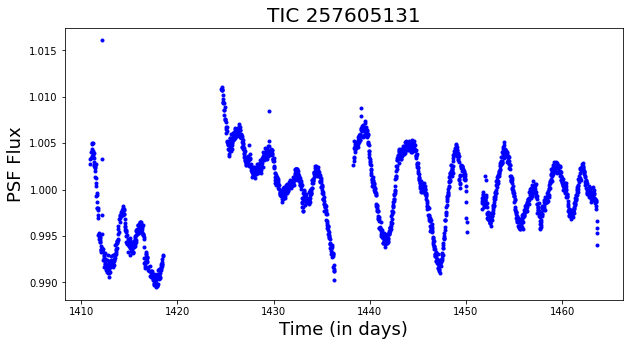

In [3]:
for target in targets:
    plotter.plot_psf(target)

As you can see by the sinusoidal variation in the light curve, it's a very variable star. As such, we need to remove (or detrend) the variability in order to recover the planet.

Note: If you are unhappy with the detrending, you canmanually choose the maximunm number of splines that are used by using the max_splines keyword in the detrend_lightcurve function.

Detrending LightCurve of TIC 257605131
Using a default sigma clipping of 2 for TIC 257605131!


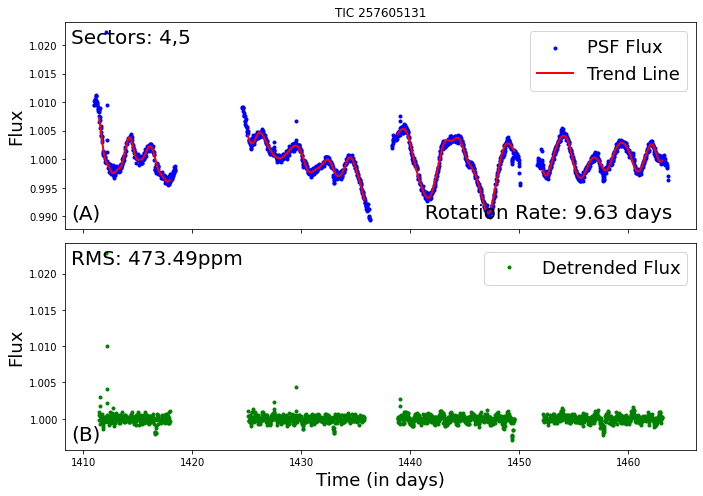

In [4]:
for target in targets:
    target.detrend_lightcurve(method = 'penalized', Verbose = False)
    plotter.lightcurve_detrended(target)

- Let's pause to analyse what's going on the in plot. Note: RMS is the root mean square of the light curve and can be thought about as a meansure of how 'noisy' the light curve is.
- In the upper panel, the red line is the variability trend that the code calculates (using the penalized spline) from the PSF light curve (in blue). This red line is then divided out fromt the PSF light curve which gives us the (relatively) flat light curve in green (lower panel).
- We will be using this flat green light curve in order to search for the planet.
- But before we do that, you can visally see the dips in the green light curve - a known planet TOI 451d!

For the search, we are looking for a minimum of two transits because only a single transit can be due to false positives

Searching in TIC 257605131
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 42 durations
Searching 1806 data points, 6593 periods from 0.5 to 24.991 days
Using all 4 CPU threads


100%|██████████| 6593/6593 periods | 00:21<00:00



TLS found a TCE in TIC 257605131


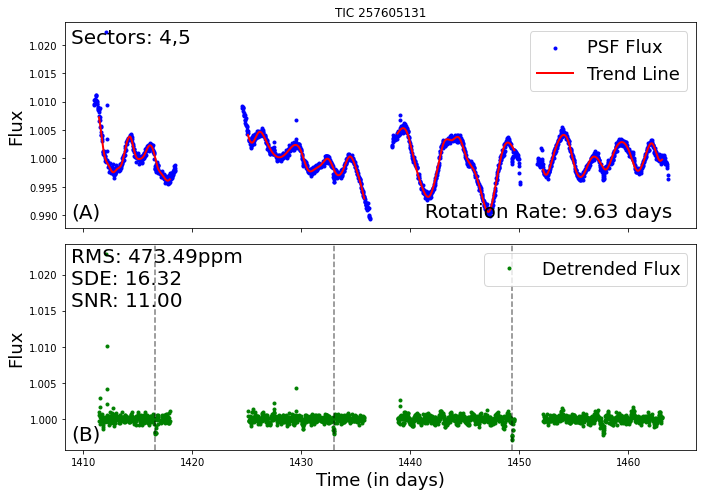

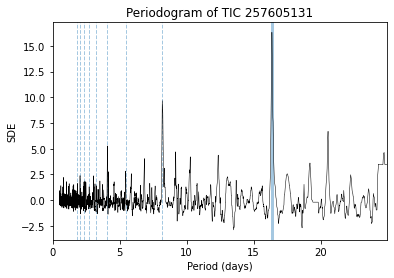

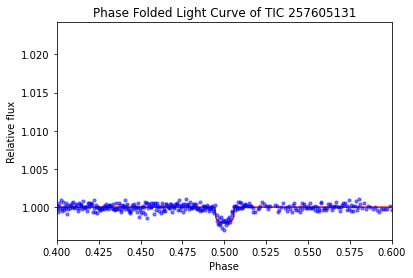

In [5]:
for target in targets:
    target.search(n_transits_min = 2, snr_cut = 7, sde_cut = 7, doPlot = True)

- The first plot again shows the detrending process in the upper panel and the detrended light curve in the lower panel. But this time, the dashed vertical lines show the location of where the transits occur.
- The second plot is a periodogram. A periodogram is a useful tool which helps us identify the most dominant frequency. Here, it's about 16.36 days (blue vertical highlight) which is the period of the planet.
- The last plot is the phase folded light curve. This plot is created using the histogram. It folds the detrended light curve along the orbital period of the planet such that each transit overlaps each other. This creates a much clear view of the transit depth and duration which is then fit (obscured red line) in order to get the planet parameters.

Now that we have found the planet, let's vet the signal. First, we have to make sure that the light curve isn't contaminated by the flux from a nearby/background star and calculate the flux conotribution of our target star. We will also do a centroid test that will help determine whether the transiting signal is coming from the star itself.

Calculating Flux Ratio of TIC 257605131
Sector:  4


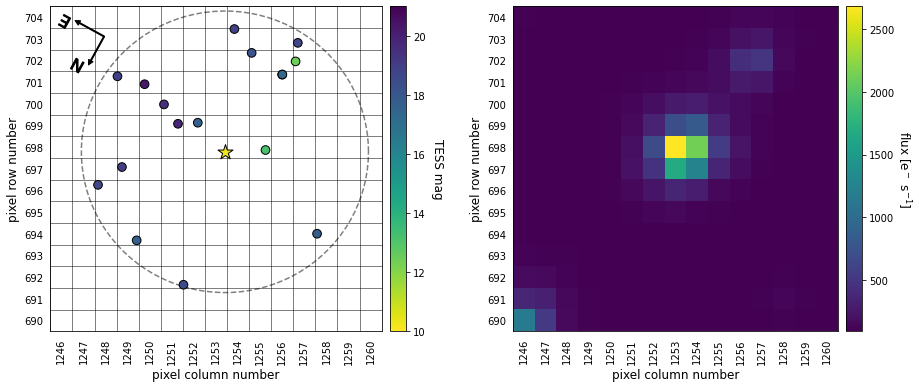

Sector:  5


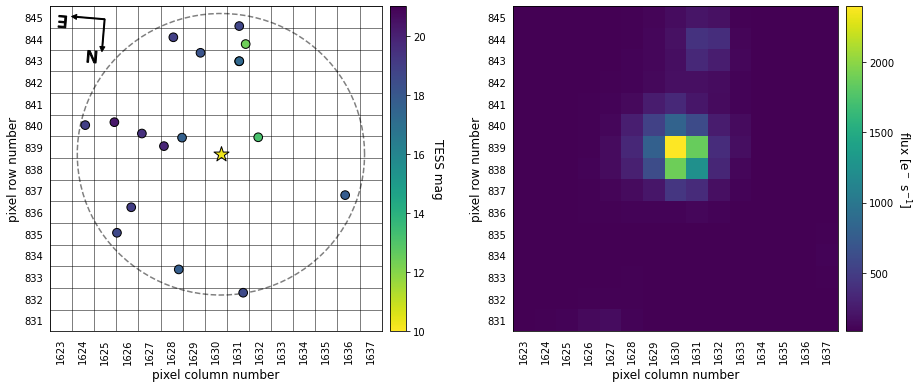

No apertures provided, assuming 5x5 centered on target.
(saved flux_ratios/257605131/fratio.npz)
Flux ratio (in %): 95.06718335693984


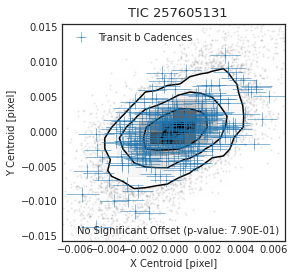

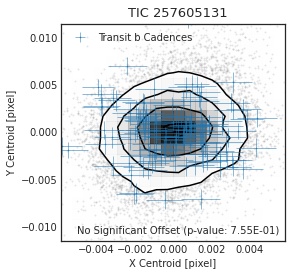

In [6]:
for target in targets:
    vetting.flux_contamination(target, Verbose = False, doPlot = True, Overwrite = False)
    print('Flux ratio (in %):',target.fluxratio*100)
    vetting.TESS_centroid_test(target, target.planet['P'], target.planet['T0'], target.planet['tdur_obs'])

Since most of the flux is coming from our taget star and no signaficant offset was detected during the centroid test, we can safely say that the transiting signal is coming from our target. Now, we can vet the planet signal itself to make sure that it's not caused by instrumental or detrending effects.

This vetting step uses techniques that were used by Kepler's Robovetter and K2's EDIVetter.

In [7]:
for target in targets:   
    vetting.vetting(target, tdur_cutoff = 0.75, tdepth_cutoff = 1.5, Verbose = True)

Running Vetting routine...
Single Transit:  False
Orbital Period Similar to Stellar Rotation Period:  False
Orbital Period Similar to half Stellar Rotation Period:  False
Inconsistent Transit Depths:  False
Observed Transit Duration Inconsistent with Expected transit Duration:  False
EDIVetter Individual Transit Test:  False
EDIVetter Odd/Even Transit Variation:  False

TCE passed all vetting tests! 
PoI found in TIC 257605131
  SDE = 16.3
  SNR = 11.0
  Period  = 16.37 days
  Period error = 0.06945 days
  Radius = 3.92 earth radii
  T0 = 1416.63
3 transit times in time series: ['1416.63010', '1433.00069', '1449.37127']
Number of data points during each unique transit [8. 8. 8.]
The number of transits with intransit data points 3
The number of transits with no intransit data points 0
Transit depth: 0.99793
Transit duration: 0.17267 days
Transit depths (mean) [0.99827965 0.99851794 0.9979518 ]
Transit depth uncertainties [0.00013201 0.00016273 0.00024965]
Radius ratio of planet and star

Our planet signal passed all the instrumental false alarm vetting! 
So now, it's time to vet the phase folded light curve to make sure that the transit is due to a planet and not due to an astrophysical fasle positive.

Vetting the phase-folded light curve of TIC 257605131
No apertures provided, assuming 5x5 centered on target.
Calculating TP scenario probabilitiey for 257605131.
Calculating EB and EBx2P scenario probabilities for 257605131.
Calculating PTP scenario probability for 257605131.
Calculating PEB and PEBx2P scenario probabilities for 257605131.
Calculating STP scenario probability for 257605131.
Calculating SEB and SEBx2P scenario probabilities for 257605131.
Calculating DTP scenario probability for 257605131.
Calculating DEB and DEBx2P scenario probabilities for 257605131.
Calculating BTP scenario probability for 257605131.
Calculating BEB and BEBx2P scenario probabilities for 257605131.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 257605132.
False Positive Probability:  0.0479
Nearby False Positive Probability:  0.0021
    ID         scenario    M_s     R_s     P_orb    inc      b       ecc     w         R_p      M_EB    R_EB    prob
--  ---------  ----------  ------  ----

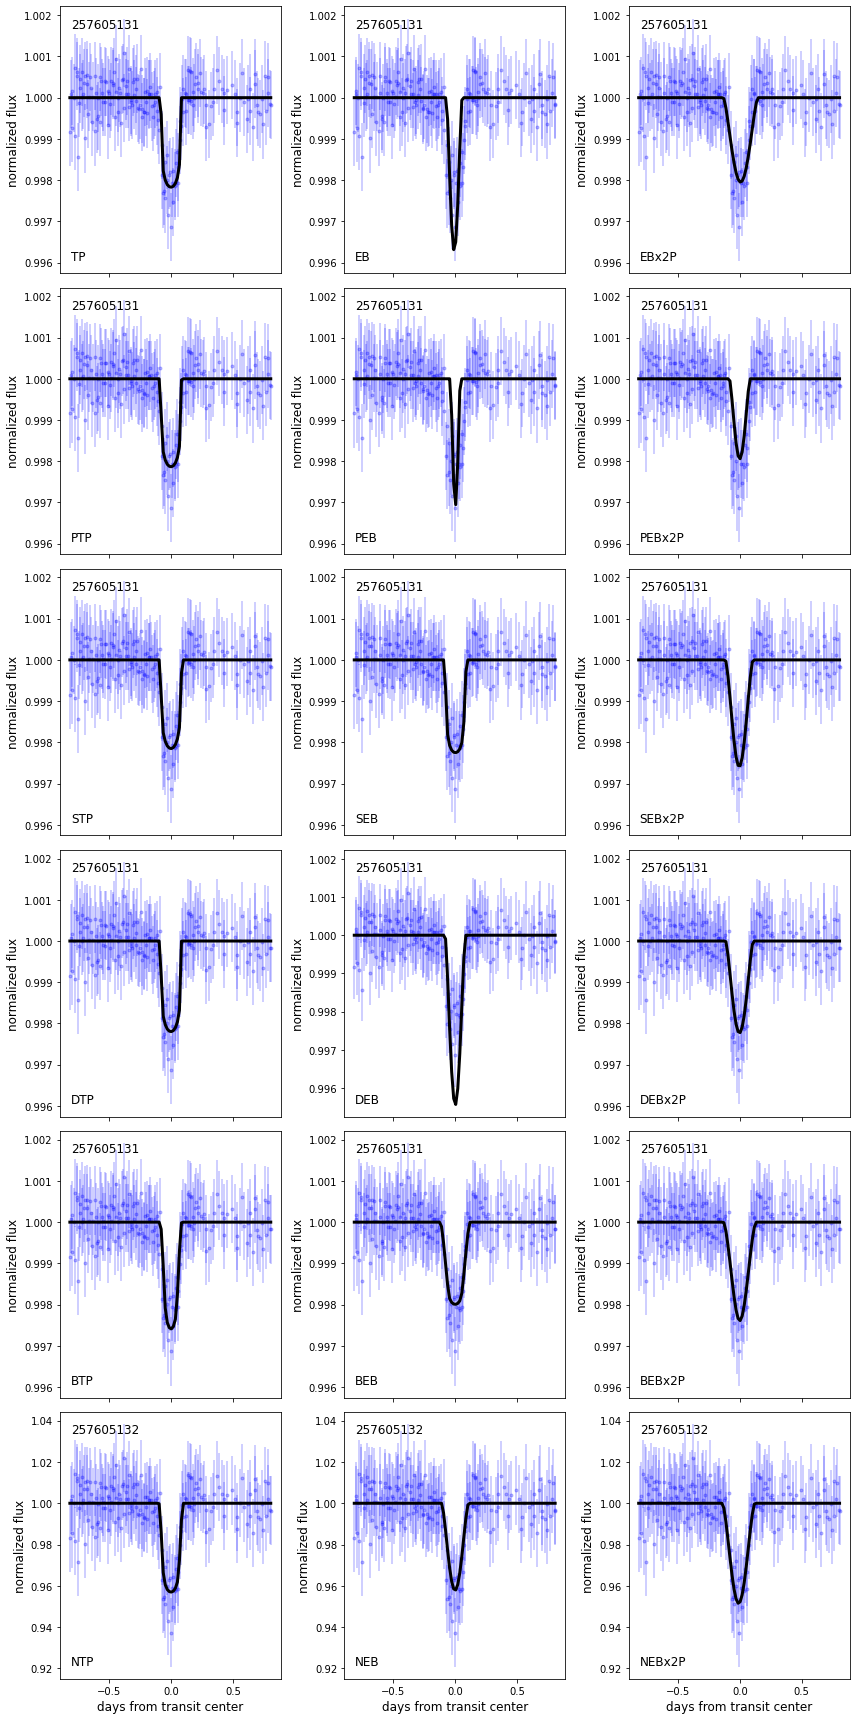

In [8]:
for target in targets:
    vetting.vet_phase_fold_lc(target, phase_min = 0.45, phase_max = 0.55, flatpriors = False)

As expected, this transit singal passes all our vetting tests and pterodactyls is able to identify this transit signal correctly.